In [1]:
# loading in and transforming data
import os
import torch
import torchvision
from torch.autograd import Variable

# Visualizing data
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Import a testframe:

In [2]:
import imageio
from imageio import get_reader

In [3]:
mov = get_reader('./data/targets/1D02F690.tif')

In [4]:
frame = []
for i, item in enumerate(mov):
    frame.append(item[:,:,0])
frame = np.array([frame])
_,_, r, c = frame.shape
frame = frame[:,:,:int(r/2),:int(c/2)]
print(frame.shape)

(1, 1, 384, 384)


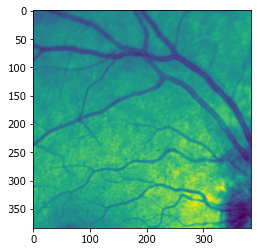

In [5]:
fig, ax = plt.subplots(1,1)
ax.cla()
ax.imshow(frame[0,0,:,:])

## Create datasets

In [7]:
import DataSet
from DataSet import RetinaDataset
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, DataLoader

In [8]:
train_data = RetinaDataset(file_path="/data/train", transforms=[ToTensor()])
train_target = RetinaDataset(file_path="/data/targets", transforms=[ToTensor()])

## Begin modelling:

In [9]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [11]:
# residual block class
class ResidualBlock(nn.Module):
    
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [13]:
# Creates transformation matrix
def transformationMatrix(dim, stride, batch_size, torch_=True):
    t = np.zeros([batch_size, dim, dim], dtype=float)
    for i in range(dim):
        if i % stride == 0:
            t[:,i,i] = 0
        else:
            t[:,i,i] = 1
    if torch_:
        t = torch.tensor(t, dtype=float, device=torch.device("cuda:0")).float()
    return t

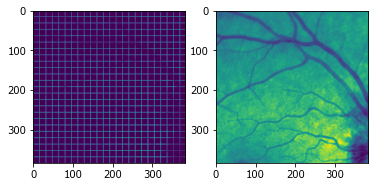

In [14]:
# Test the transformation matrix:
t_test = torch.unsqueeze(torch.tensor(transformationMatrix(384, 2**4, 1, torch_=False)), 1).numpy()
f_edit = frame-np.matmul(np.matmul(t_test, frame), t_test)
# Visualize picture:
fig, ax = plt.subplots(1,2)
ax[0].cla()
ax[0].imshow(f_edit[0,0])
ax[1].imshow(frame[0,0])

In [15]:
class Generator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=2):
        super(Generator, self).__init__()
        
        # 1. Define the encoder part
        # initial convolutional layer given, below
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 1, kernel_size=4, batch_norm=False)
        
        
    def forward(self, inpt):
        # Extracts nonzero vertical and horizontal lines
        lines = inpt-torch.matmul(torch.matmul(t, inpt), t)
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary
        out = F.relu(self.conv1(lines))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = self.res_blocks(out)
        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = torch.tanh(self.deconv3(out))
        # Adds vertical and horizontal lines
        out = lines + torch.matmul(torch.matmul(t, out), t)
        return out

In [16]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(1, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, inpt):
        # relu applied to all conv layers but last
        out_x = F.relu(self.conv1(inpt))
        out_x = F.relu(self.conv2(out_x))
        out_x = F.relu(self.conv3(out_x))
        out_x = F.relu(self.conv4(out_x))
        out_x = self.conv5(out_x)
        return out_x

## Create network

In [17]:

# Creates the model to be used.
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=2):
    """Builds the generators and discriminators."""
    
    device = torch.device("cuda:0")
    
    # Instantiate generators
    generator=Generator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    
    # Instantiate discriminators
    discriminator = Discriminator(conv_dim=d_conv_dim)
    
    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        generator.to(device)
        discriminator.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return generator, discriminator



In [18]:
# Create model
batch_size=2
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0)
target_loader = DataLoader(dataset=train_target, batch_size=batch_size, shuffle=True, num_workers=0)
t = torch.unsqueeze(transformationMatrix(768, 2**2, batch_size),1)
generator, discriminator = create_model()

Models moved to GPU.


## Optimization criteria:

In [19]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean((D_out)**2)

In [20]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr= 0.00002
beta1=0.5
beta2=0.999

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(generator.parameters(), lr, [beta1, beta2])
d_optimizer = optim.Adam(discriminator.parameters(), lr, [beta1, beta2])

## Training code:

In [21]:
# train the network
def training_loop(train_loader, target_loader, n_epochs=1000):
    print_every=20
    
    # keep track of losses over time
    losses = []
    losses_test = []
    
    # Make iterators
    iter_X = iter(train_loader)
    iter_Y = iter(target_loader)
    batches_per_epoch = min(len(iter_X), len(iter_Y))
    
    c=1
    for epoch in range(1, n_epochs+1):
        print(c)
        c+=1

        # Reset iterators if left-over data does not fill a batch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(train_loader)
            iter_Y = iter(target_loader)
        
        # Get batch of train and target data
        X = scale(iter_X.next()) 
        T = scale(iter_Y.next()) 
            
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        X = X.to(device)
        T = T.to(device)
            
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_T = discriminator(T)
        D_T_real_loss = real_mse_loss(out_T)
        
        # Train with fake images
        # 2. Generate fake images that look like domain X based on real images in domain Y
        T_fake = generator(X)
        
        # 3. Compute the fake loss for D_X
        out_T_fake = discriminator(T_fake)
        D_T_fake_loss = fake_mse_loss(out_T_fake)
        
        # 4. Compute the total loss and perform backprop
        d_x_loss = D_T_real_loss + D_T_fake_loss
        d_x_loss.backward()
        d_optimizer.step()
    
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
    
        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()
    
        # 1. Generate fake images that look like domain X based on real images in domain Y
        T_fake = generator(X)

        # 2. Compute the generator loss based on domain X
        out_T_fake = discriminator(T_fake)
        g_T_real_loss = real_mse_loss(out_T_fake)

        # 3. Preform backprop:
        g_T_real_loss.backward()
        g_optimizer.step()


        # Logging info
        if epoch % print_every == 0:
            print("Train loss: ")
            print("Dsicriminator: ", str(d_x_loss))
            print("Generator: ", str(g_T_real_loss))
                
            losses.append((d_x_loss.item(), g_T_real_loss.item()))
                
            #print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
            #        epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            #sample_every=300
            # Save the generated samples
            #if epoch % sample_every == 0:
            #    G_YtoX.eval()
            #    G_XtoY.eval()
            #    save_samples(epoch, fixed_Y, fixed_labels_Y, fixed_X, fixed_labels_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan_run_fulldata')
            #    G_YtoX.train()
            #    G_XtoY.train()

            #checkpoint_every=1000
            # Save the model parameters
            #if epoch % checkpoint_every == 0 or epoch == 1:
            #    checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan_run_fulldata')

    return losses


In [22]:
# Train model:
n_epochs = 5
losses = training_loop(train_loader, target_loader, n_epochs=n_epochs)

1
2
3
4
5


## Try a test image:

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_pic = train_data[0]
train_pic = torch.unsqueeze(scale(train_pic),1).to(device)

In [24]:
generator.eval()
test_out = generator(train_pic).data.cpu().numpy()
generator.train()

Generator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_layer2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1)

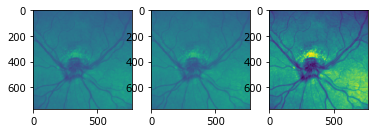

In [25]:
fig, ax = plt.subplots(1,3)
#ax.cla()
ax[0].imshow(test_out[0,0,:,:])
ax[1].imshow(train_pic.data.cpu().numpy()[0,0,:,:]-torch.matmul(t, torch.matmul(train_pic, t)).data.cpu().numpy()[0,0,:,:])
ax[2].imshow(train_pic.data.cpu().numpy()[0,0,:,:])